In [1]:
from tools.modelData import ModelData
from boltz.boltzmannEq import dYdx, computeCollisionTerms,computeDecayTerms
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from tools.configParserWrapper import ConfigParserExt
import os
from tools.logger import setLogLevel

### Load input parameters

In [2]:
parfile = './input_parameters_FO.ini'
parser = ConfigParserExt(inline_comment_prefixes="#")   
ret = parser.read(parfile)
parser = parser.expandLoops()[0]
parserDict = parser.toDict(raw=False)

In [3]:
pars = parser['SolverParameters']
atol = 0.0
rtol = 1e-4
T0 = pars['T0']
Tf = pars['Tf']
method = 'Radau'
nsteps = 500
outputFolder = os.path.abspath(parser['Options']['outputFolder'])
bannerFile = os.path.join(outputFolder,'darkcalc_banner.txt')
dm = parser['Model']['darkmatter']
bsmList = []
if 'bsmParticles' in parser['Model']:
    bsmList = str(parser['Model']['bsmParticles']).split(',')
model = ModelData(dmPDG=dm, bsmPDGList=bsmList, bannerFile=bannerFile)
    

compDict = model.componentsDict
mDM = compDict[model.dmPDG].mass
x0 = mDM/T0
xf = mDM/Tf  
xvals = np.geomspace(x0,xf,1000)  


In [4]:
# Set initila conditions
y0 = np.array([comp.Yeq(T0) for comp in compDict.values()])    
if 'initialConditions' in pars:
    # Set initila conditions
    initialCond = pars['initialConditions']    
    for label,comp_y0 in initialCond.items():
        pdg = model.convert2PDG(label)
        comp = compDict[pdg]            
        if isinstance(comp_y0,float):
            y0[comp.ID] = y0
        elif comp_y0.lower() in ['eq', 'equilibrium']:
            continue # Already set


### Check terms in initial conditions

In [5]:
for comp in compDict.values():
    print(comp,y0[comp.ID],comp.Yeq(mDM/x0))

SM 0.2776566338315371 0.2776566338315371
xd 0.007802996735312518 0.007802996735312518


In [6]:
coll = computeCollisionTerms(x0,y0,model)
dec = computeDecayTerms(x0,y0,model)
print(coll)
print(dec)

[{}, {'xdxdx_ddx': np.float64(0.0), 'xdxdx_uux': np.float64(0.0), 'xdxdx_ssx': np.float64(0.0), 'xdxdx_ccx': np.float64(0.0), 'xdxdx_bbx': np.float64(0.0), 'xdxdx_ttx': np.float64(0.0)}]
[{'decay': 0.0, 'injection': 0.0}, {'decay': 0.0, 'injection': 0.0}]


### Solve equations

In [26]:
# # Run solve following Gabriela's prescription
# sol = solve_ivp(dYdx, [x0,9], y0, args=(model,), atol = 10**(-12), rtol = 10**(-12), method='BDF', 
#                 t_eval=np.geomspace(x0,9,50))
# y = sol.y[:]
# x = sol.t[:]
# sol = solve_ivp(dYdx, [sol.t[-1],11], sol.y[:,-1], args=(model,), atol = 10**(-12), rtol = 10**(-12), method='LSODA', max_step = 0.08,
#                 t_eval=np.geomspace(9,11,50))
# y = np.hstack((y,sol.y))
# x = np.hstack((x,sol.t))
# sol = solve_ivp(dYdx, [sol.t[-1],28], sol.y[:,-1], args=(model,), atol = 10**(-13), rtol = 10**(-13), method='LSODA', max_step = 0.08,
#                 t_eval=np.geomspace(11,28,50))
# y = np.hstack((y,sol.y))
# x = np.hstack((x,sol.t))
# sol = solve_ivp(dYdx, [sol.t[-1],xf], sol.y[:,-1], args=(model,), atol = 10**(-12), rtol = 10**(-12), method='LSODA', max_step = 0.04,
#                 t_eval=np.geomspace(28,xf,50))
# y = np.hstack((y,sol.y))
# x = np.hstack((x,sol.t))

sol = solve_ivp(dYdx, [x0,xf], y0, args=(model,), atol = atol, 
                    rtol = rtol, method=method, t_eval=xvals)
x = sol.t
y = sol.y

In [27]:
x_sol = x
y_sol = y

In [28]:
y_sol.shape

(2, 1000)

In [29]:
sigmaV = np.zeros(len(xvals))
Cabcd = np.zeros(len(xvals))
ydiff = np.zeros(len(xvals))
for i,xv in enumerate(xvals):
    stot = sum([proc.sigmaV(xv) 
                for proc in model.collisionProcesses])
    sigmaV[i] = stot
    T = model.mDM/xv
    ydiff[i] = (y_sol[1,i]-compDict[57].Yeq(T))
    for process in model.collisionProcesses:
        initialPDGs = process.initialPDGs
        finalPDGs = process.finalPDGs
        # Compute collision term:
        a_pdg,b_pdg = initialPDGs
        c_pdg, d_pdg = finalPDGs
        a = compDict[a_pdg]
        b = compDict[b_pdg]
        c = compDict[c_pdg]
        d = compDict[d_pdg]    
        r_eq = a.Yeq(T)*b.Yeq(T)
        if r_eq > 0.0:
            r_eq = r_eq/(c.Yeq(T)*d.Yeq(T))
        # Multiply sigma by Yeq_i*Yeq_j for convenience
        # then we just need to multiply by ratios
        Cabcd[i] += process.sigmaV(xv)*(y_sol[a.ID,i]*y_sol[b.ID,i] - a.Yeq(T)*b.Yeq(T))

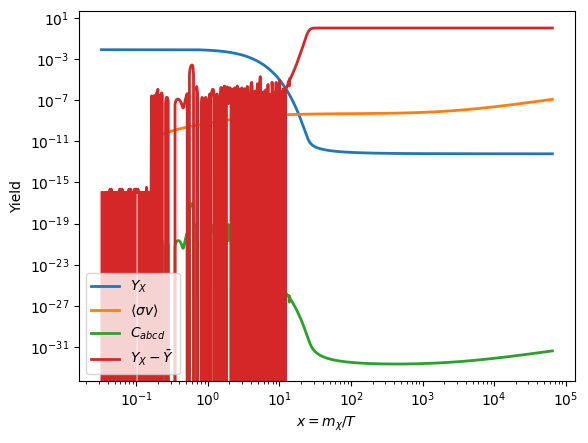

In [35]:
# fig = plt.figure(figsize=(10,8))
plt.plot(x_sol,y_sol[1,:],  linewidth=2, label = r'$Y_{X}$')
plt.plot(xvals,sigmaV, linewidth=2, label = r'$\langle \sigma v \rangle$')
plt.plot(xvals,Cabcd,  linewidth=2, label = r'$C_{abcd}$')
plt.plot(xvals,ydiff/y_sol[1,:],  linewidth=2, label = r'$Y_{X}-\bar{Y}$')

# plt.plot(x,y[2,:], 'b', linewidth=2, label = r'$Y_{\chi}$')
# plt.plot(x_sol,y_sol[2,:], 'b', linewidth=2, label = r'$Y_{\chi}$',linestyle='dashed')

plt.xlabel(r'$x = m_{\chi}/T$')
plt.ylabel('Yield')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
Ytot = sum(y_sol[1:,-1])
omh2 = 0.12*Ytot/(6.8e-13)
print(f"Omegah2 = {omh2:1.3f}")

Omegah2 = 0.107
